In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%cd ..

/Users/purzelrakete/src/github.com/feldberlin/wavenet


In [2]:
import os

import numpy as np
import torch
import librosa
from torch.nn import functional as F
import matplotlib.pyplot as plt
import librosa.display
import IPython.display as ipd
from tqdm import tqdm

from wavenet import model, train, sample, audio, datasets, utils, viz

# Train on Tiny

A full training run with the big model, against tiny. Should absolutely crush it. 

In [3]:
dry = True 
if dry: os.environ['WANDB_MODE'] = 'disabled'

In [4]:
n, m = 30, 5_000
ds, ds_test = datasets.Tiny(n, m), datasets.Tiny(n, m)
X, Y = datasets.to_tensor(ds)

In [5]:
m = model.Wavenet(
    model.HParams(
        mixed_precision=False,
        n_audio_chans=1, 
        n_classes=2*n, 
        compress=False, 
        sample_length=n, 
        n_chans=32,
        dilation_stacks=1,
        n_layers=6
    )
)

tp =  train.HParams(
    max_epochs=15, 
    batch_size=64, 
    num_workers=1, 
    learning_rate=0.01
)

t = train.Trainer(m, ds, ds_test, tp, None)
t.train()

15:78 loss 0.47809 lr 7.585954e-08: 100%|██████████| 79/79 [00:03<00:00, 21.32it/s]


## Sample

In [6]:
def sample(model, n_samples = 48):
    generated = X.new_zeros((n_samples,) + X.size()[1:])
    flat = generated.view(generated.size(0), -1)

    # sampling
    for t in range(flat.size(1)):
        x = (generated.float() - ds.mean) / ds.std
        y, _ = model(x)
        logits = y[:, :, 0, t]
        dist = torch.distributions.categorical.Categorical(logits = y[:, :, 0, t])
        flat[:, t] = dist.sample()
        
    return generated

In [7]:
generated = sample(m)

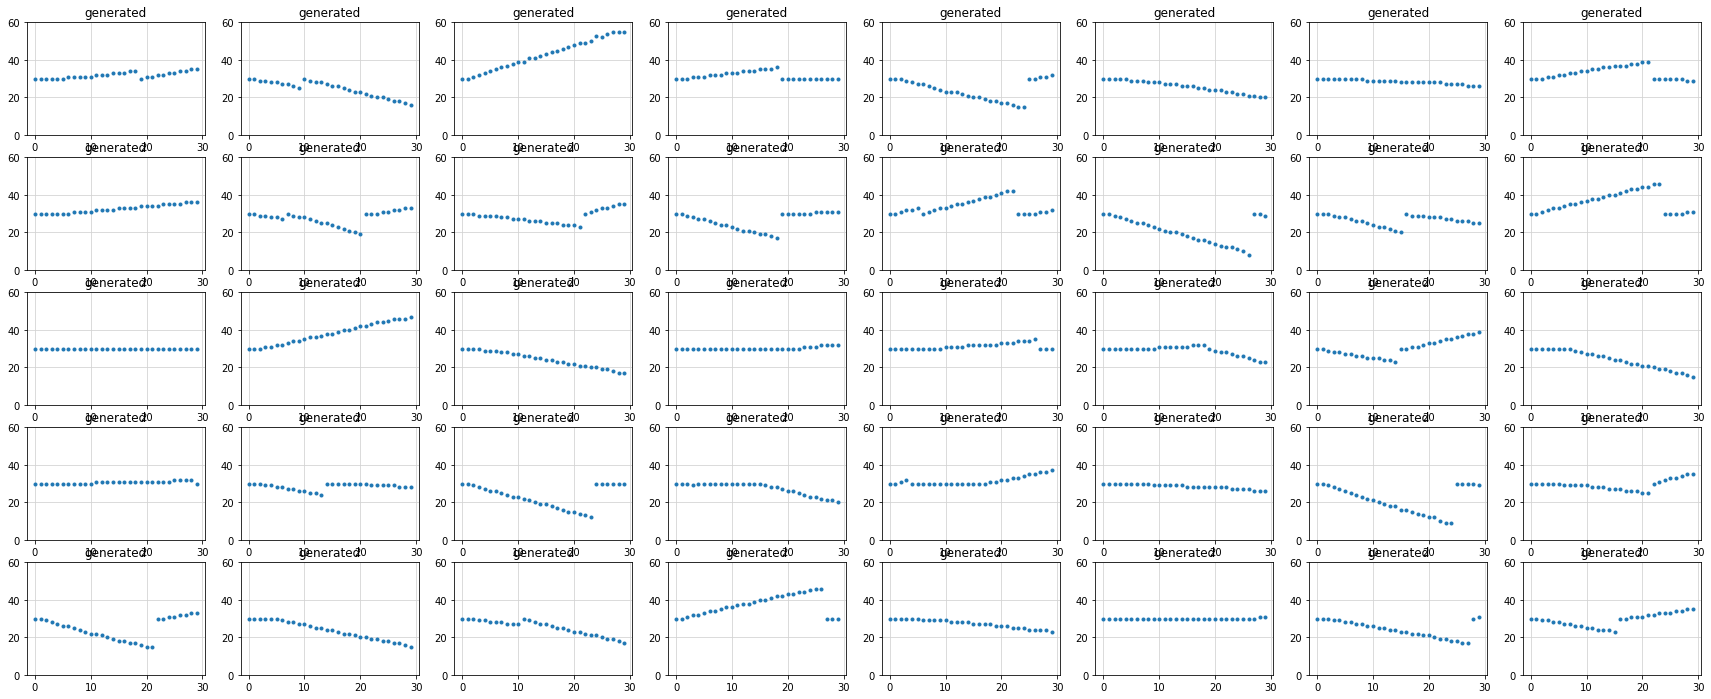

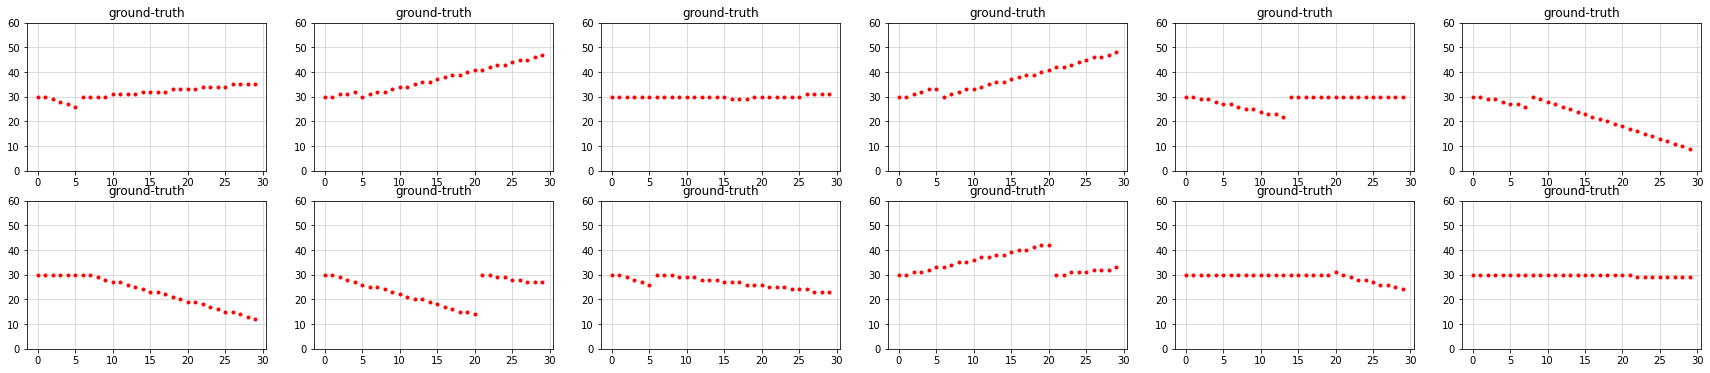

In [8]:
plt.subplots(figsize=(30, 12))
for i in range(40):
    plt.subplot(5, 8, i+1)
    plt.ylim(0, 2*n)
    plt.grid(color='lightgray')
    plt.plot(torch.arange(n), generated[i, 0], '.')
    plt.title('generated')
    
plt.subplots(figsize=(30, 6))
for i in range(12):
    plt.subplot(2, 6, i+1)
    plt.ylim(0, 2*n)
    plt.grid(color='lightgray')
    plt.plot(torch.arange(n), Y[i].squeeze(), '.', color='red')
    plt.title('ground-truth')